In [1]:
#Libraries and function definition

from pandas import DataFrame
from pandas import concat

from math import sqrt
from numpy import concatenate
from numpy import array
from numpy import hstack

from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

#settings for graphics
import numpy as np
import keras
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(17, 6)})


#Divide Dataset intro train and test sets
def split_data(dataset,split):
    n_train_hours = int(len(dataset) * split)
    train=dataset.iloc[:n_train_hours].to_numpy()
    test=dataset.iloc[n_train_hours:].to_numpy()
    print("Total obs: {}, training obs:{}, test obs:{}".format(len(dataset),n_train_hours,len(dataset)-n_train_hours))
    return train,test

# Standarize data based on train set
def scale(train, test):
    #calculation of scaling statistics has to be conducted on training data 
    #and must then be applied to the test data, Otherwise, you use future information at the time of forecasting 
    # which commonly biases forecasting metrics in a positive direction:
    scaler = RobustScaler() # or with minmax feature_range=(-1, 1)
    scaler = scaler.fit(train) # fit scaler
    train_scaled = scaler.transform(train) # transform train
    test_scaled = scaler.transform(test) # transform test
    print("Train and Test set scaled")
    return scaler, train_scaled, test_scaled

# Split a multivariate sequence into samples of the form [Xt-in...Xt0]=[Yt+1...Yt+out]
# target variable must be the last column.
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


#Invert Scaling element
def invert_scale_Xy(scaler, X_sample,Y_sample):
    XY_array=np.hstack((X_sample[-n_steps_out:,:], Y_sample.reshape(Y_sample.shape[0],1)))
    inverted = scaler.inverse_transform(XY_array)
    return inverted[0:, -1]

# MAPE calculation
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Evaluate one or more hourly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    MAE,MSE,RMSE,MAPE = [],[],[],[]
    # calculate an error score for each hour predicted
    for i in range(actual.shape[1]):
        mae= mean_absolute_error(actual[:, i], predicted[:, i])# calculate mae
        MAE.append(mae) # store
        mse = mean_squared_error(actual[:, i], predicted[:, i])# calculate mse
        MSE.append(mse)
        rmse = sqrt(mse)# calculate rmse
        RMSE.append(rmse) # store
        mape=mean_absolute_percentage_error(actual[:, i], predicted[:, i])
        MAPE.append(mape)
    scores=pd.DataFrame(list(zip(MAE,RMSE,MAPE)),columns=['MAE','RMSE','MAPE'])
    scores.index = ['t+'+str(i) for i in range(1,len(scores)+1)]
    scores.loc['mean'] = scores.mean()
    return scores


import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR) # ignore warnings from tensorflow

import os
import pandas as pd
directory = os.getcwd()
os.chdir(os.path.abspath(os.path.join(directory, os.pardir)))# change dir to parent folder

Using TensorFlow backend.


In [2]:
# 0 # LOAD  DATASET:
df=pd.read_excel(os.getcwd()+"\\2 Data Explore\Dataset.xlsx",sep=';',index_col=0)#,usecols=range(0,9))
#df=df[df.columns[list(range(1,8))+[0]]]
os.chdir(directory)
print("NaN tweet rows: ",len(df)-df['X.tweets'].dropna().count())
print("from {} , equivalent to {}% of total data dropped".format(len(df),round(100*(len(df)-df['X.tweets'].dropna().count())/len(df),2)))
df=df.dropna()

print(len(df))
df.head()

NaN tweet rows:  786
from 18757 , equivalent to 4.19% of total data dropped
17883


,Close,Volume.BTC,Volume.USD,Gtrends,X.tweets,AdrActCnt,TxTfrValMeanUSD,TxTfrValMeanNtv,NVTAdj90,RSI,TRIX,MACDhist
Datetime,,,,,,,,,,,,
2017-07-05 03:00:00,2550.96,550.75,1408018.24,3.672459,454.0,649605.0,9048.309937,3.476368,32.841126,42.043947,0.097154,-6.586065
2017-07-05 04:00:00,2535.35,638.17,1620776.27,3.591746,486.0,649605.0,9048.309937,3.476368,32.841126,38.161506,0.093222,-7.498749
2017-07-05 05:00:00,2560.22,490.48,1249478.44,3.470675,447.0,649605.0,9048.309937,3.476368,32.841126,46.619068,0.089275,-6.108594
2017-07-05 06:00:00,2547.65,190.61,486318.59,3.511032,426.0,649605.0,9048.309937,3.476368,32.841126,43.389010,0.085208,-5.723350
2017-07-05 07:00:00,2538.11,407.90,1035958.79,3.349605,448.0,649605.0,9048.309937,3.476368,32.841126,41.063591,0.080966,-5.781747


In [3]:
Basic_DS=df[['Volume.BTC','Volume.USD','Close']]
Basic_DS.name='Basic_DS'

Social_DS=df[['Volume.BTC','Volume.USD','Gtrends','X.tweets','Close']]  #Social(5)
Social_DS.name='Social_DS'

Fundamental_DS=df[['AdrActCnt','TxTfrValMeanUSD','NVTAdj90','Volume.USD','Volume.BTC','Close']] #daily Fundamentals(6)
Fundamental_DS.name='Fund_DS'

Technical_DS=df[['RSI', 'TRIX', 'MACDhist','Volume.USD','Volume.BTC','Close']] #Technical(6)
Technical_DS.name='Tech_DS'

Ranked_DS=df[['Volume.USD','Volume.BTC','Gtrends','X.tweets','NVTAdj90','TxTfrValMeanUSD','Close']] #Best_ranked(7)
Ranked_DS.name='Ranked_DS'

Datasets=[Basic_DS,Social_DS,Fundamental_DS,Technical_DS,Ranked_DS]

In [4]:
# 1 # PREPARE DATA FOR LSTM:
def Prepare_for_LSTM(DS,Split,N_in,N_out):
    train,test=split_data(DS,Split) #Split train and test
    scaler, train_scaled, test_scaled=scale(train,test) #Standarize/Scale
    # Reframe to supervised learning [samples,time_steps,features]:
    X_train,y_train=split_sequences(train_scaled,N_in,N_out)
    X_test,y_test=split_sequences(test_scaled,N_in,N_out)
    print("Train reframed to X:{} and y:{}".format(X_train.shape,y_train.shape))
    print("Test reframed to X:{} and y:{}".format(X_test.shape,y_test.shape))
    return X_train,y_train,X_test,y_test,scaler

In [5]:
# 2 # Build and SET Models (VECTOR OUTPUT)
#     define model Stacked LTSM 3 layer output vector for multistep forecast:
def Set_Model_vector_output(neurons,dropout,epochs,batch_size,X_train,y_train):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
    model.add(Dropout(dropout))# 1st LSTM layer with dropout regularization.
    model.add(LSTM(units = neurons, return_sequences = True))
    model.add(Dropout(dropout))# 2nd LSTM layer with dropout regularization.
    model.add(LSTM(units = neurons, return_sequences = False))
    model.add(Dropout(dropout))# 3rd LSTM layer with dropout regularization.
    model.add(Dense(y_train.shape[1]))#Output layer
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model

In [6]:
# Dataset Parameters:
Split = 0.8      # Training Data portion
n_steps_in = 12  # number of timesteps as input
n_steps_out = 12  # number of timesteps as output (vector lenght)
# Common  training parameters:
verbose = 1  # print or not Fit process
epochs = 120 # max number of epochs
patience = 11 # Early stoping point check

#Chosen hyperparameters:
neurons=50
drop=0.20
batch_size=64

Models=[]
Histories=[]

for data in Datasets:
    print('\n Number of columns: ',len(data.columns))
    X_train,y_train,X_test,y_test,scaler=Prepare_for_LSTM(data,Split,n_steps_in,n_steps_out)
    
    #y_train_reshaped = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    #y_test_reshaped = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))
    
    
    model=Set_Model_vector_output(neurons,drop,epochs,batch_size,X_train,y_train)
    Models.append(model)
    # train/fit model
    es = EarlyStopping(monitor='val_loss', verbose=1,patience=patience,restore_best_weights=True) #early stop if loss starts to increase
    #mc = ModelCheckpoint('Stacked_vector_for_'+str(data)+'.h5', monitor='val_loss', verbose=1,save_best_only=True)
    history=model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2,validation_data=(X_test, y_test),shuffle=False, callbacks=[es])#,mc])
    Histories.append(history)



 Number of columns:  3
Total obs: 17883, training obs:14306, test obs:3577
Train and Test set scaled
Train reframed to X:(14284, 12, 2) and y:(14284, 12)
Test reframed to X:(3555, 12, 2) and y:(3555, 12)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 50)            10600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dro

Train on 14284 samples, validate on 3555 samples
Epoch 1/120
 - 11s - loss: 0.2348 - val_loss: 0.3482
Epoch 2/120
 - 9s - loss: 0.2992 - val_loss: 0.5268
Epoch 3/120
 - 9s - loss: 0.1967 - val_loss: 0.2405
Epoch 4/120
 - 9s - loss: 0.2220 - val_loss: 0.1368
Epoch 5/120
 - 9s - loss: 0.1383 - val_loss: 0.1458
Epoch 6/120
 - 8s - loss: 0.1070 - val_loss: 0.1088
Epoch 7/120
 - 8s - loss: 0.0620 - val_loss: 0.1119
Epoch 8/120
 - 7s - loss: 0.0546 - val_loss: 0.1154
Epoch 9/120
 - 7s - loss: 0.0445 - val_loss: 0.1111
Epoch 10/120
 - 8s - loss: 0.0402 - val_loss: 0.0871
Epoch 11/120
 - 7s - loss: 0.0379 - val_loss: 0.0749
Epoch 12/120
 - 8s - loss: 0.0363 - val_loss: 0.0647
Epoch 13/120
 - 8s - loss: 0.0341 - val_loss: 0.0549
Epoch 14/120
 - 8s - loss: 0.0349 - val_loss: 0.0613
Epoch 15/120
 - 7s - loss: 0.0307 - val_loss: 0.0468
Epoch 16/120
 - 8s - loss: 0.0306 - val_loss: 0.0425
Epoch 17/120
 - 9s - loss: 0.0293 - val_loss: 0.0429
Epoch 18/120
 - 8s - loss: 0.0307 - val_loss: 0.0426
Epoch

Epoch 00084: early stopping

 Number of columns:  7
Total obs: 17883, training obs:14306, test obs:3577
Train and Test set scaled
Train reframed to X:(14284, 12, 6) and y:(14284, 12)
Test reframed to X:(3555, 12, 6) and y:(3555, 12)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 12, 50)            11400     
_________________________________________________________________
dropout_13 (Dropout)         (None, 12, 50)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 12, 50)            20200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 12, 50)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)                20200     
_________________________________________

In [7]:
RESULTS=[]
Originals=[]
SCORES=[]
for i in range(len(Models)):
        
    X_train,y_train,X_test,y_test,scaler=Prepare_for_LSTM(Datasets[i],Split,n_steps_in,n_steps_out)
    Y_predicted=Models[i].predict(X_test)
    
    Y_rescaled=[]
    for j in range(len(Y_predicted)):
        Y_rescaled.append(invert_scale_Xy(scaler,np.vstack((X_test[j],X_test[j])),Y_predicted[j]))
    Y_predicted=array(Y_rescaled)
    RESULTS.append(Y_predicted)
    
    Y_rescaled=[]
    for k in range(len(Y_predicted)):
        Y_rescaled.append(invert_scale_Xy(scaler,np.vstack((X_test[k],X_test[k])),y_test[k]))
    Y_orig=array(Y_rescaled)
    Originals.append(Y_orig)
    
    score=evaluate_forecasts(Y_orig,Y_predicted)
    SCORES.append(score)

Total obs: 17883, training obs:14306, test obs:3577
Train and Test set scaled
Train reframed to X:(14284, 12, 2) and y:(14284, 12)
Test reframed to X:(3555, 12, 2) and y:(3555, 12)
Total obs: 17883, training obs:14306, test obs:3577
Train and Test set scaled
Train reframed to X:(14284, 12, 4) and y:(14284, 12)
Test reframed to X:(3555, 12, 4) and y:(3555, 12)
Total obs: 17883, training obs:14306, test obs:3577
Train and Test set scaled
Train reframed to X:(14284, 12, 5) and y:(14284, 12)
Test reframed to X:(3555, 12, 5) and y:(3555, 12)
Total obs: 17883, training obs:14306, test obs:3577
Train and Test set scaled
Train reframed to X:(14284, 12, 5) and y:(14284, 12)
Test reframed to X:(3555, 12, 5) and y:(3555, 12)
Total obs: 17883, training obs:14306, test obs:3577
Train and Test set scaled
Train reframed to X:(14284, 12, 6) and y:(14284, 12)
Test reframed to X:(3555, 12, 6) and y:(3555, 12)


In [8]:
[print('\n'+Datasets[i].name+'\n', SCORES[i]) for i in range(len(SCORES))]


Basic_DS
               MAE         RMSE       MAPE
t+1   1068.672229  1335.215171  15.144644
t+2   1003.350429  1258.159771  14.125374
t+3    998.939057  1259.628512  13.747107
t+4   1028.719897  1288.836185  14.463679
t+5   1062.476549  1325.968486  14.958315
t+6   1075.373759  1337.835450  15.162467
t+7   1077.253862  1336.780933  15.318950
t+8   1112.188848  1363.694389  15.656698
t+9   1078.807987  1344.801852  15.151486
t+10  1111.261132  1380.322312  15.796443
t+11  1048.444550  1311.201419  14.423842
t+12  1094.674169  1362.909044  15.286761
mean  1063.346872  1325.446127  14.936314

Social_DS
              MAE        RMSE      MAPE
t+1   219.418526  338.729661  2.793556
t+2   231.965306  350.967708  2.930563
t+3   240.099678  357.730604  3.019244
t+4   249.216723  367.674422  3.110060
t+5   254.667912  373.848939  3.175622
t+6   262.105031  383.191315  3.245094
t+7   272.982263  396.118969  3.355561
t+8   279.890791  402.558128  3.437814
t+9   290.004138  416.208955  3.549443

[None, None, None, None, None]

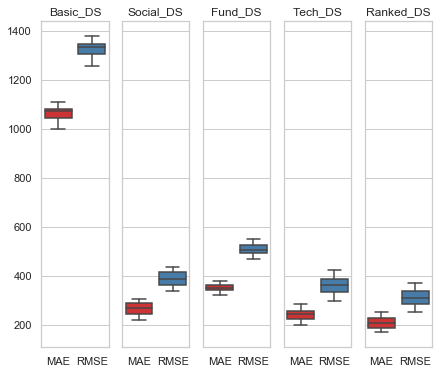

In [9]:
sns.set(style="whitegrid",palette="Set1")#,rc={'figure.figsize':(3, 3)})
f, axes = plt.subplots(1,len(SCORES) , figsize=(7, 6), sharex=False,sharey=True)
for H in range(len(SCORES)):
    sns.boxplot(data=SCORES[H][['MAE','RMSE']][:-1],ax=axes[H]).set_title(str(Datasets[H].name))

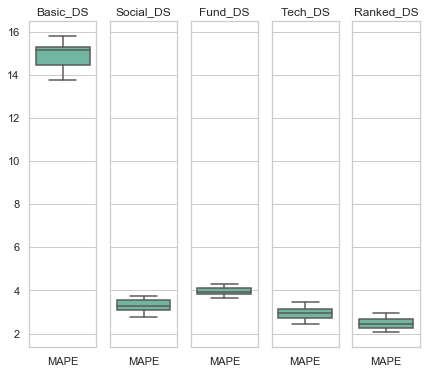

In [10]:
sns.set(style="whitegrid",palette="Set2")#,rc={'figure.figsize':(3, 3)})
f, axes = plt.subplots(1, len(SCORES), figsize=(7, 6), sharex=False,sharey=True)
for H in range(len(SCORES)):
    sns.boxplot(data=SCORES[H][['MAPE']][:-1],ax=axes[H]).set_title(str(Datasets[H].name))

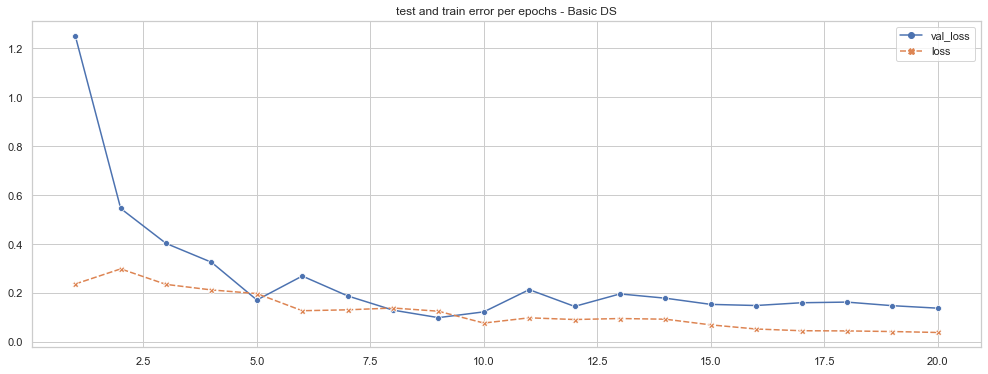

In [11]:
sns.set(rc={'figure.figsize':(17, 6)})
Data=pd.DataFrame(Histories[0].history,index=range(1,len(Histories[0].history['loss'])+1))
with sns.axes_style("whitegrid"):
    ax=sns.lineplot(data=Data,markers=True).set_title('test and train error per epochs - Basic DS')

Text(0.5, 1.0, 'True vs Ranked_DS forecast of  Vector output model')

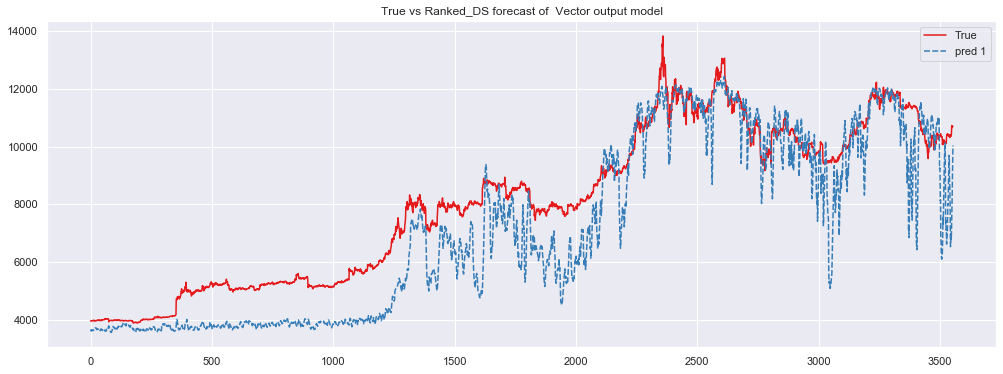

In [12]:
sns.set(rc={'figure.figsize':(17, 6)},palette="Set1")
cols=['True']+['pred '+str(i) for i in range(1,n_steps_out+1)]
Data=pd.DataFrame(np.hstack((Originals[2][:,0].reshape(Originals[2][:,0].shape[0],1),RESULTS[0])),columns=cols)
sns.lineplot(data=Data[['True','pred 1']]).set_title('True vs Ranked_DS forecast of  Vector output model')

In [13]:
Predictions=[str(Df[Df['RMSE']==Df['RMSE'].min()].index.values).replace("['t+",'pred ').replace("']","") for Df in SCORES]
B_COL=[int(str(Df[Df['RMSE']==Df['RMSE'].min()].index.values).replace("['t+",'').replace("']",""))-1 for Df in SCORES]
cols=['True price']+[Datasets[i].name+' Forecast' for  i in range(len(Datasets))]
cols

['True price',
 'Basic_DS Forecast',
 'Social_DS Forecast',
 'Fund_DS Forecast',
 'Tech_DS Forecast',
 'Ranked_DS Forecast']

Text(0.5, 1.0, 'True vs Best predicted VECTOR OUTPUT')

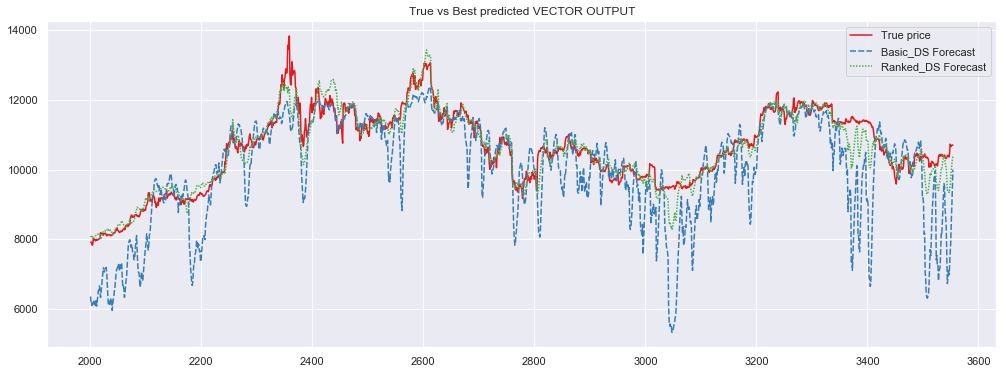

In [14]:
Y_true=Originals[0]
Data1=pd.DataFrame(np.hstack((Y_true[:,0].reshape(Y_true[:,0].shape[0],1),array([RESULTS[d][:,B_COL[d]] for d in range(len(Datasets))]).transpose() )),columns=cols)
sns.set(rc={'figure.figsize':(17, 6)},palette="Set1")
sns.lineplot(data=Data1[['True price','Basic_DS Forecast','Ranked_DS Forecast']][Data.index>2000],palette='Set1').set_title('True vs Best predicted VECTOR OUTPUT')

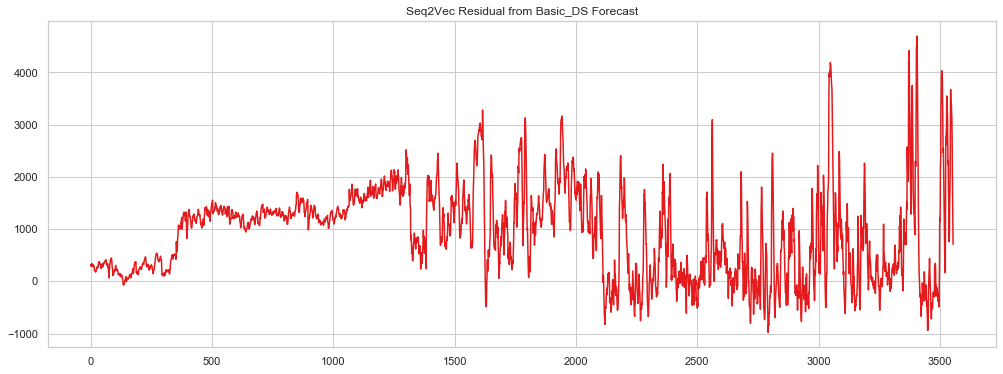

In [15]:
residual = Data1['True price']-Data1['Basic_DS Forecast']
with sns.axes_style("whitegrid"):
    ax=sns.lineplot(data=residual).set_title('Seq2Vec Residual from Basic_DS Forecast')

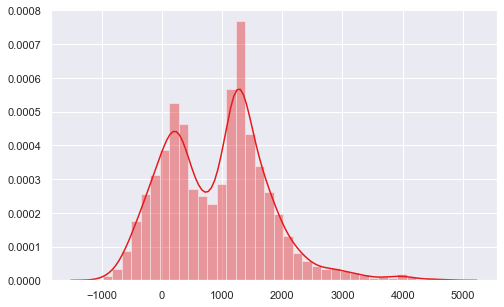

In [16]:
fig, ax = pyplot.subplots(figsize=(8, 5))
sns.distplot(residual,ax=ax);

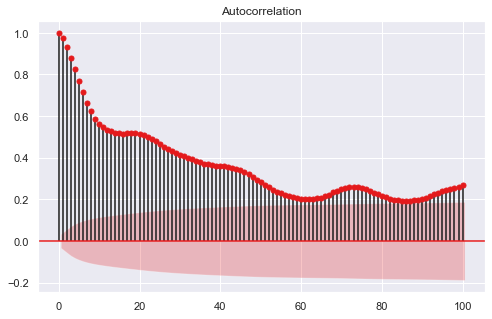

In [17]:
import statsmodels.api as sm
fig, ax = pyplot.subplots(figsize=(8, 5))
sm.graphics.tsa.plot_acf(residual.values.squeeze(), lags=100,ax=ax)
plt.show()